# Lab 4 - Linear models

We focus on models in the form 

$$ y ~ \mathrm{Normal}(\alpha+X\beta,\sigma) $$

or in generalized form (generalized linear models)

$$ f(y) ~ \mathrm{Normal}(\alpha+X\beta,\sigma) $$

where $f(y)$ is a link function, for example - logit.


In [414]:
from cmdstanpy import CmdStanModel


import arviz as az
import numpy as np
import scipy.stats as stats

import matplotlib.pyplot as plt
import pandas as pd

## Excercise 1 - modelling height of !Kung people

### Normal model - no predictors
We will try to fit $\mathrm{Normal}(\mu,\sigma)$ distribution to height data. Special case of linear model with $\beta=0$.

In [415]:
_BASE_URL = "https://raw.githubusercontent.com/rmcelreath/rethinking/Experimental/data"
HOWELL_DATASET_PATH = f"{_BASE_URL}/Howell1.csv"
d = pd.read_csv(HOWELL_DATASET_PATH, sep=';', header=0)
d=d[d.age>=18] #just adults 
d.head()

,height,weight,age,male
0,151.765,47.825606,63.0,1
1,139.700,36.485807,63.0,0
2,136.525,31.864838,65.0,0
3,156.845,53.041914,41.0,1
4,145.415,41.276872,51.0,0


In [416]:
d["height"].mean()

154.59709261363636

In [417]:
model_ppc=CmdStanModel(stan_file='height_1_ppc.stan')

R = 1000
sim=model_ppc.sample(iter_sampling=R,
                     iter_warmup=0,
                     chains=1,
                     fixed_param=True,
                     seed=29042020,refresh=R)

INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
chain 1 |██████████| 00:00 Sampling completed


INFO:cmdstanpy:CmdStan done processing.


In [418]:
sim.summary()

,Mean,MCSE,StdDev,5%,50%,95%,N_Eff,N_Eff/s,R_hat
name,,,,,,,,,
lp__,0.0,NaN,0,0.00,0.0,0.0,NaN,NaN,NaN
mu,180.0,0.63,20,140.00,180.0,210.0,1000.0,95000.0,1.0
sigma,15.0,0.48,15,0.74,9.7,44.0,960.0,87000.0,1.0
height,180.0,0.99,31,130.00,180.0,230.0,950.0,87000.0,1.0


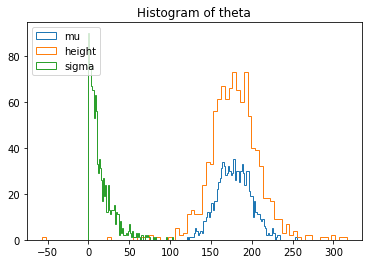

In [419]:
plt.figure
plt.title("Histogram of theta")
plt.hist(sim.stan_variable('mu'), bins=80, label= "mu", histtype='step')
plt.hist(sim.stan_variable('height'), bins=80, label= "height", histtype='step')
plt.hist(sim.stan_variable('sigma'), bins=80, label= "sigma", histtype='step')
plt.legend(loc="upper left")
plt.show()

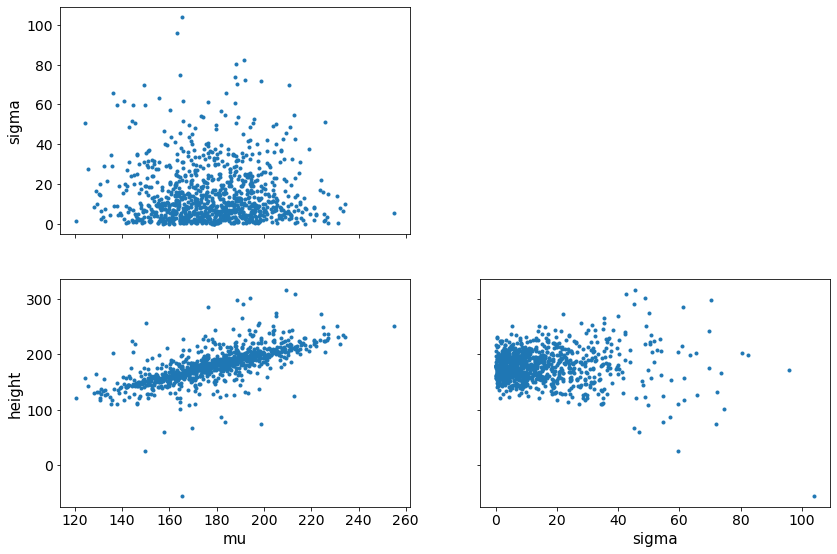

In [420]:
data = az.convert_to_dataset(sim)
az.plot_pair(data)
plt.show()

#### Task 1. Prior predictive checks

1. Plot histograms of mu, sigma and simulated height.
2. Plot a joint distribution of mu and sigma.
3. Check if samples are consistent with priors
4. Check if observed data is possible to obtain using priors.

In [421]:
model_1_fit=CmdStanModel(stan_file='height_1_fit.stan')

INFO:cmdstanpy:found newer exe file, not recompiling


In [422]:
fit=model_1_fit.sample(data=dict(N=len(d),
                                   heights=d.height.values),
                         seed=28052020)

INFO:cmdstanpy:CmdStan start procesing
chain 1 |          | 00:00 Status


chain 1 |██████████| 00:00 Sampling completed
chain 2 |██████████| 00:00 Sampling completed

chain 3 |██████████| 00:00 Sampling completed


chain 4 |██████████| 00:00 Sampling completed


INFO:cmdstanpy:CmdStan done processing.


In [423]:
fit.summary()

,Mean,MCSE,StdDev,5%,50%,95%,N_Eff,N_Eff/s,R_hat
name,,,,,,,,,
lp__,-900.0,0.0250,0.98,-900.0,-900.0,-900.0,1600.0,9600.0,1.0
mu,150.0,0.0074,0.41,150.0,150.0,160.0,3100.0,19000.0,1.0
sigma,7.8,0.0050,0.29,7.3,7.8,8.3,3400.0,21000.0,1.0
height,150.0,0.1200,7.60,140.0,150.0,170.0,4200.0,26000.0,1.0


#### Task 2. Model fit and evaluation

1. Plot a joint distribution of fitted mu and sigma.
2. Plot histograms of data and simulated heights and evaluate the quality of model.



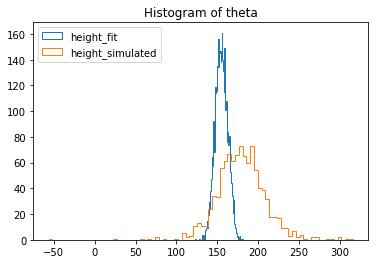

In [424]:
plt.figure
plt.title("Histogram of theta")
#plt.hist(fit.stan_variable('mu'), bins=80, label= "mu", histtype='step')
plt.hist(fit.stan_variable('height'), bins=80, label= "height_fit", histtype='step')
plt.hist(sim.stan_variable('height'), bins=80, label= "height_simulated", histtype='step')
#plt.hist(fit.stan_variable('sigma'), bins=80, label= "sigma", histtype='step')
plt.legend(loc="upper left")
plt.show()

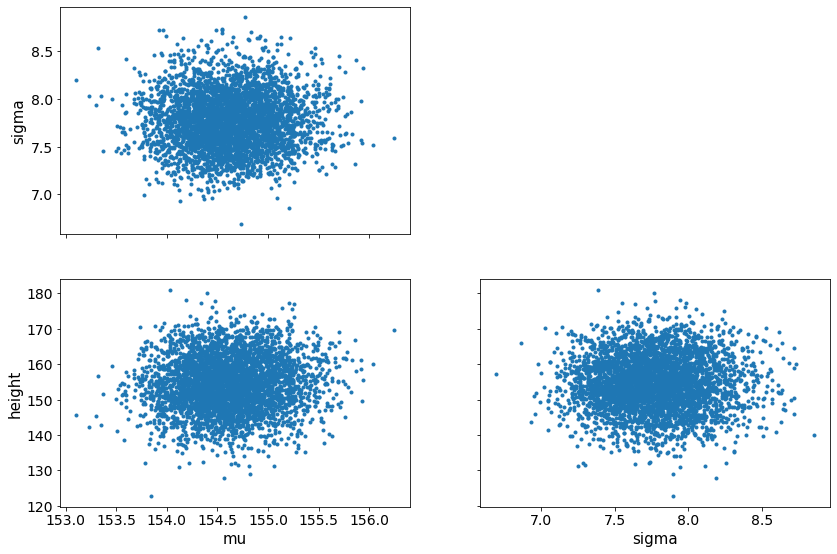

In [425]:
data_fit = az.convert_to_dataset(fit)
az.plot_pair(data_fit)
plt.show()

### Adding predictor to the model - weight

Create column ```c_weight``` in the dataframe containing weights substrated by their mean.


In [426]:
i=0
array_w=[]
array_w.clear()
w_mean=d["height"].mean()
for w in d["height"]:
    array_w.append(w-w_mean)
    i=i+1
d.insert(4,"c_weight",array_w)
d    

,height,weight,age,male,c_weight
0,151.765,47.825606,63.0,1,-2.832093
1,139.700,36.485807,63.0,0,-14.897093
2,136.525,31.864838,65.0,0,-18.072093
3,156.845,53.041914,41.0,1,2.247907
4,145.415,41.276872,51.0,0,-9.182093
...,...,...,...,...,...
534,162.560,47.031821,27.0,0,7.962907
537,142.875,34.246196,31.0,0,-11.722093
540,162.560,52.163080,31.0,1,7.962907
541,156.210,54.062497,21.0,0,1.612907


In [427]:
model_ppc=CmdStanModel(stan_file='height_2a_ppc.stan')
R = 1000
data_sim={'N':50, 'weight':np.linspace(d.c_weight.min(),d.c_weight.max(),num=50)}
sim=model_ppc.sample(data=data_sim, 
                     iter_sampling=R, 
                     iter_warmup=0, 
                     chains=1, 
                     refresh=R,
                     fixed_param=True,
                     seed=29042020)

INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
chain 1 |██████████| 00:00 Sampling completed                      


INFO:cmdstanpy:CmdStan done processing.


In [428]:
sim.summary()

,Mean,MCSE,StdDev,5%,50%,95%,N_Eff,N_Eff/s,R_hat
name,,,,,,,,,
lp__,0.00,NaN,0,0.00,0.00,0.0,NaN,NaN,NaN
alpha,180.00,0.64,20,150.00,180.00,210.0,990.0,14000.0,1.0
beta,0.21,0.35,10,-17.00,-0.37,17.0,850.0,12000.0,1.0
sigma,15.00,0.45,15,0.72,10.00,45.0,1100.0,15000.0,1.0
height[1],174.00,6.30,184,-125.00,183.00,484.0,855.0,11711.0,1.0
height[2],175.00,6.00,175,-104.00,186.00,468.0,865.0,11845.0,1.0
height[3],174.00,5.80,166,-95.00,183.00,441.0,831.0,11390.0,1.0
height[4],176.00,5.40,158,-84.00,184.00,437.0,852.0,11673.0,1.0
height[5],175.00,5.10,150,-65.00,182.00,411.0,854.0,11698.0,1.0


In [429]:
x = np.linspace(d.c_weight.min(),d.c_weight.max(),num=50)
x

array([-18.07209261, -17.20382731, -16.335562  , -15.4672967 ,
       -14.59903139, -13.73076608, -12.86250078, -11.99423547,
       -11.12597016, -10.25770486,  -9.38943955,  -8.52117425,
        -7.65290894,  -6.78464363,  -5.91637833,  -5.04811302,
        -4.17984772,  -3.31158241,  -2.4433171 ,  -1.5750518 ,
        -0.70678649,   0.16147881,   1.02974412,   1.89800943,
         2.76627473,   3.63454004,   4.50280535,   5.37107065,
         6.23933596,   7.10760126,   7.97586657,   8.84413188,
         9.71239718,  10.58066249,  11.44892779,  12.3171931 ,
        13.18545841,  14.05372371,  14.92198902,  15.79025433,
        16.65851963,  17.52678494,  18.39505024,  19.26331555,
        20.13158086,  20.99984616,  21.86811147,  22.73637677,
        23.60464208,  24.47290739])

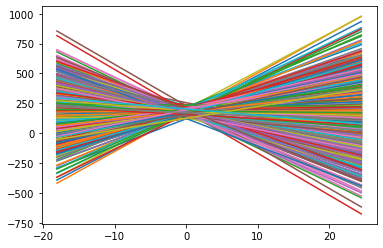

In [430]:
for alpha, beta in zip(sim.stan_variable('alpha'), sim.stan_variable('beta')):
    y = alpha + beta * x
    plt.plot(x, y)

#### Task 4. Prior predictive checks
1. Plot lines for each sampled slope beta and intercept alpha, verify if possible predicted heights are consistent with minimum (0) and maximum (check Wikipedia) heights observed in nature.

### Modifying prior

If prior for beta admits negative values, then it makes no sense. Lets change prior to lognormal distribution.


In [431]:
model_ppc=CmdStanModel(stan_file='height_2b_ppc.stan')

INFO:cmdstanpy:found newer exe file, not recompiling


In [433]:
sim=model_ppc.sample(data=data_sim, 
                     iter_sampling=R, 
                     iter_warmup=0, 
                     chains=1, 
                     refresh=R,
                     fixed_param=True,
                     seed=29042020)

INFO:cmdstanpy:CmdStan start procesing
chain 1 |██████████| 00:00 Sampling completed


INFO:cmdstanpy:CmdStan done processing.


#### Task 5. Prior predictive checks
1. Plot lines for each sampled slope beta and intercept alpha, verify if possible predicted heights are consistent with minimum (0) and maximum (check Wikipedia) heights observed in nature.
2. For each fitulated weight plot maximum, minimum, and 5, 25, 50, 75, 95 quantiles of fitulated weight (all in the same plot). Compare with observed data. Is observed data possible within the prior model?

In [434]:
sim.summary()

,Mean,MCSE,StdDev,5%,50%,95%,N_Eff,N_Eff/s,R_hat
name,,,,,,,,,
lp__,0.0,NaN,0.0,0.00,0.00,0.0,NaN,NaN,NaN
alpha,180.0,0.640,20.0,150.00,180.00,210.0,990.0,16000.0,1.0
beta,1.7,0.078,2.3,0.19,0.96,5.5,850.0,14000.0,1.0
sigma,15.0,0.450,15.0,0.72,10.00,45.0,1100.0,17000.0,1.0
height[1],147.0,1.700,50.0,73.00,154.00,204.0,883.0,14468.0,1.0
height[2],149.0,1.600,49.0,78.00,155.00,208.0,895.0,14671.0,1.0
height[3],150.0,1.600,46.0,77.00,157.00,203.0,833.0,13650.0,1.0
height[4],152.0,1.500,45.0,84.00,157.00,209.0,898.0,14716.0,1.0
height[5],153.0,1.500,44.0,91.00,157.00,208.0,838.0,13746.0,1.0


In [435]:
x = np.linspace(d.c_weight.min(),d.c_weight.max(),num=50)
x

array([-18.07209261, -17.20382731, -16.335562  , -15.4672967 ,
       -14.59903139, -13.73076608, -12.86250078, -11.99423547,
       -11.12597016, -10.25770486,  -9.38943955,  -8.52117425,
        -7.65290894,  -6.78464363,  -5.91637833,  -5.04811302,
        -4.17984772,  -3.31158241,  -2.4433171 ,  -1.5750518 ,
        -0.70678649,   0.16147881,   1.02974412,   1.89800943,
         2.76627473,   3.63454004,   4.50280535,   5.37107065,
         6.23933596,   7.10760126,   7.97586657,   8.84413188,
         9.71239718,  10.58066249,  11.44892779,  12.3171931 ,
        13.18545841,  14.05372371,  14.92198902,  15.79025433,
        16.65851963,  17.52678494,  18.39505024,  19.26331555,
        20.13158086,  20.99984616,  21.86811147,  22.73637677,
        23.60464208,  24.47290739])

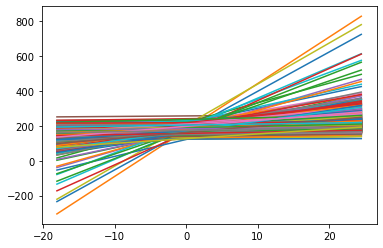

In [436]:

for alpha, beta in zip(sim.stan_variable('alpha'), sim.stan_variable('beta')):
    y = alpha + beta * x
    plt.plot(x, y)

In [437]:
len(sim.stan_variable('height')[1])

50

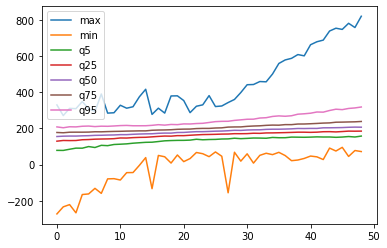

In [438]:
max =[]
min =[]
q5 =[]
q25 =[]
q50 =[]
q75 =[]
q95 =[]

for i in range(1,len(sim.stan_variable('height')[1])):
    max.append(np.max(sim.stan_variable('height')[:,i]))
    min.append(np.min(sim.stan_variable('height')[:,i]))
    q5.append(np.quantile(sim.stan_variable('height')[:,i],0.05))
    q25.append(np.quantile(sim.stan_variable('height')[:,i],0.25))
    q50.append(np.quantile(sim.stan_variable('height')[:,i],0.50))
    q75.append(np.quantile(sim.stan_variable('height')[:,i],0.75))
    q95.append(np.quantile(sim.stan_variable('height')[:,i],0.95))

plt.plot(max)
plt.plot(min)
plt.plot(q5)
plt.plot(q25)
plt.plot(q50)
plt.plot(q75)
plt.plot(q95)
plt.legend(['max','min','q5','q25','q50','q75','q95'])
plt.show()

### Fitting data


In [439]:
model_2_fit=CmdStanModel(stan_file='height_2_fit.stan')

INFO:cmdstanpy:found newer exe file, not recompiling


#### Task 6. Preparing data for fit
1. Create ```data_fit``` dictionary containing data from  ```N``` first rows of dataframe

In [440]:
N=20
df_N=d.head(N)
data_fit= {
    "N": N,
    "heights": df_N['height'],
    "weight": df_N['weight']
}
data_fit

{'N': 20,
 'heights': 0     151.7650
 1     139.7000
 2     136.5250
 3     156.8450
 4     145.4150
 5     163.8300
 6     149.2250
 7     168.9100
 8     147.9550
 9     165.1000
 10    154.3050
 11    151.1300
 12    144.7800
 13    149.9000
 14    150.4950
 15    163.1950
 16    157.4800
 17    143.9418
 21    161.2900
 22    156.2100
 Name: height, dtype: float64,
 'weight': 0     47.825606
 1     36.485807
 2     31.864838
 3     53.041914
 4     41.276872
 5     62.992589
 6     38.243476
 7     55.479971
 8     34.869885
 9     54.487739
 10    49.895120
 11    41.220173
 12    36.032215
 13    47.700000
 14    33.849303
 15    48.562694
 16    42.325803
 17    38.356873
 21    48.987936
 22    42.722696
 Name: weight, dtype: float64}

In [441]:
fit=model_2_fit.sample(data=data_fit,seed=28052020)


INFO:cmdstanpy:CmdStan start procesing
chain 1 |          | 00:00 Status





chain 1 |██▋       | 00:00 Iteration:  400 / 2000 [ 20%]  (Warmup)
chain 1 |███████▎  | 00:00 Iteration: 1300 / 2000 [ 65%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


INFO:cmdstanpy:CmdStan done processing.


#### Task 7. Evaluating model

1. Plot lines for each sampled slope beta and intercept alpha. Verify how uncertainity changes with increasing of sample (N)
2. For each simulated weight plot maximum, minimum, and 5, 25, 50, 75, 95 quantiles of simulated weight (all in the same plot). Compare with observed data (N points). Is observed data possible within the posterior model? What changes when N increases.


In [442]:
x = np.linspace(d.c_weight.min(),d.c_weight.max(),num=50)
x

array([-18.07209261, -17.20382731, -16.335562  , -15.4672967 ,
       -14.59903139, -13.73076608, -12.86250078, -11.99423547,
       -11.12597016, -10.25770486,  -9.38943955,  -8.52117425,
        -7.65290894,  -6.78464363,  -5.91637833,  -5.04811302,
        -4.17984772,  -3.31158241,  -2.4433171 ,  -1.5750518 ,
        -0.70678649,   0.16147881,   1.02974412,   1.89800943,
         2.76627473,   3.63454004,   4.50280535,   5.37107065,
         6.23933596,   7.10760126,   7.97586657,   8.84413188,
         9.71239718,  10.58066249,  11.44892779,  12.3171931 ,
        13.18545841,  14.05372371,  14.92198902,  15.79025433,
        16.65851963,  17.52678494,  18.39505024,  19.26331555,
        20.13158086,  20.99984616,  21.86811147,  22.73637677,
        23.60464208,  24.47290739])

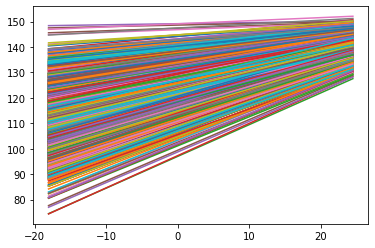

In [443]:
for alpha, beta in zip(fit.stan_variable('alpha'), fit.stan_variable('beta')):
    y = alpha + beta * x
    plt.plot(x, y)

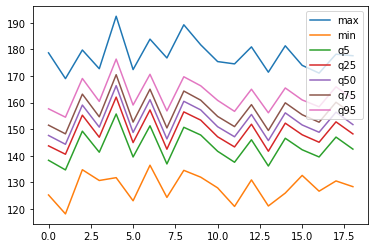

In [444]:
max =[]
min =[]
q5 =[]
q25 =[]
q50 =[]
q75 =[]
q95 =[]

for i in range(1,len(fit.stan_variable('height')[1])):
    max.append(np.max(fit.stan_variable('height')[:,i]))
    min.append(np.min(fit.stan_variable('height')[:,i]))
    q5.append(np.quantile(fit.stan_variable('height')[:,i],0.05))
    q25.append(np.quantile(fit.stan_variable('height')[:,i],0.25))
    q50.append(np.quantile(fit.stan_variable('height')[:,i],0.50))
    q75.append(np.quantile(fit.stan_variable('height')[:,i],0.75))
    q95.append(np.quantile(fit.stan_variable('height')[:,i],0.95))

plt.plot(max)
plt.plot(min)
plt.plot(q5)
plt.plot(q25)
plt.plot(q50)
plt.plot(q75)
plt.plot(q95)
plt.legend(['max','min','q5','q25','q50','q75','q95'])
plt.show()